In [1]:
# extract information from dump file.
import numpy as num
import matplotlib.pyplot as plt
import pylab as lab
from scipy import constants
%matplotlib inline
from matplotlib import rcParams

#setting different parameteres
params = {
    'font.family':'serif',
   'axes.labelsize': 14,
   'font.size': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [5,5]
   }
rcParams.update(params)

In [9]:

def DumpExtractor(filename,frames,atomNumber,atomPlate):

    
    """
infoDict=DumpExtractor(filename,frames,atomNumber,atomPlate)


Function that extracts the information from the .dump file created by openmd
    
    
    Inputs:
  ===========
   
   
   filename:
   
               Path of the dump file from which the information is to be extracted
               
    frame:
    
                Total number of frames in the dump file
                
    atomNumber:
        
                Totla number of atoms in the slab or crystal
                
    atomPlate:
    
                Total number of atoms in the capacitor plates



    Outputs:
 =============
 
 infoDict:
 
         Dictonary containing position, velocity, chargeQV, electricField, plateEQV.
         Postion is a list of [x,y,z] and each x,y,z are array of x[frames][sites]
         velocity is a list of [vx,vy,vz] and each vx,vy,vz are array of vx[frames][sites]
         chargeQV is a lisf of [c,cv] and each c and cv are array of c[frame][sites]
         electric field is list of [ex,ey,ez] and each are array of ex[frame][sites]
         plateEQV is the list of [pex,pey,pez,pc,pcv] and each are array of pex[frames][sites]
"""    
    fileDump=open(filename)  #dump file for info extraction
    linesDump=fileDump.readlines()
    
    if(linesDump[-1]!="</OpenMD>\n"):
        print("Error: Incomplete file")
        sys.exit();
    processP="Wait"
    processC="Wait"


    #information storage matrix 
    #posiiton and velocity storage
    x=num.zeros((frames,atomNumber))
    y=num.zeros((frames,atomNumber))
    z=num.zeros((frames,atomNumber))
    vx=num.zeros((frames,atomNumber))
    vy=num.zeros((frames,atomNumber))
    vz=num.zeros((frames,atomNumber))


    #charge and velocity storage matrix
    c=num.zeros((frames,atomNumber))
    cv=num.zeros((frames,atomNumber))
    ex=num.zeros((frames,atomNumber))
    ey=num.zeros((frames,atomNumber))
    ez=num.zeros((frames,atomNumber))
    pc=num.zeros((frames,atomPlate))
    pcv=num.zeros((frames,atomPlate))
    pex=num.zeros((frames,atomPlate))
    pey=num.zeros((frames,atomPlate))
    pez=num.zeros((frames,atomPlate))
    efieldConverter=1.0/23.0609 # converts kcal mol^-1 to V/A
    #frame count initilization
    fCount=0
    index=0  #index for the atoms
    for line in linesDump:
        linesSplit=str.split(line)
        length=len(linesSplit)
    
        if(length!=0 and linesSplit[0]=="<StuntDoubles>" and processP=="Wait"):
            processP="Start"
            continue;
        
        elif(length!=0 and linesSplit[0]=="</StuntDoubles>" and processP=="Start"):
            processP="Wait"
            index=0
            continue;
        
        elif(length!=0 and linesSplit[0]=="<SiteData>" and processC=="Wait"):
            processC="Start"
            continue;
        
        elif(length!=0 and linesSplit[0]=="</SiteData>" and processC=="Start"):
            fCount=fCount+1
            index=0;
            processC="Wait"
            continue;
   
        elif(fCount>=frames):
            break;
        
        else:
            processP=processP;
            processC=processC;
            
        
        
        if (processP=="Start"):
            x[fCount][int(linesSplit[0])]=float(linesSplit[2])
            y[fCount][int(linesSplit[0])]=float(linesSplit[3])
            z[fCount][int(linesSplit[0])]=float(linesSplit[4])
            vx[fCount][int(linesSplit[0])]=float(linesSplit[5])
            vy[fCount][int(linesSplit[0])]=float(linesSplit[6])
            vz[fCount][int(linesSplit[0])]=float(linesSplit[7])
        
        if(processC=="Start"):
            if int(linesSplit[0])<atomNumber:
                c[fCount][int(linesSplit[0])]=float(linesSplit[3])
                cv[fCount][int(linesSplit[0])]=float(linesSplit[4])
                ex[fCount][int(linesSplit[0])]=float(linesSplit[5])*efieldConverter
                ey[fCount][int(linesSplit[0])]=float(linesSplit[6])*efieldConverter
                ez[fCount][int(linesSplit[0])]=float(linesSplit[7])*efieldConverter
            elif (int(linesSplit[0])==atomNumber and linesSplit[1]=="cwe"):
                continue
                c[fCount][int(linesSplit[0])]=float(linesSplit[2])
                cv[fCount][int(linesSplit[0])]=float(linesSplit[3])
                ex[fCount][int(linesSplit[0])]=float(linesSplit[4])*efieldConverter
                ey[fCount][int(linesSplit[0])]=float(linesSplit[5])*efieldConverter
                ez[fCount][int(linesSplit[0])]=float(linesSplit[6])*efieldConverter
            else:
                pc[fCount][int(linesSplit[1])]=float(linesSplit[3])
                pcv[fCount][int(linesSplit[1])]=float(linesSplit[4])
                pex[fCount][int(linesSplit[1])]=float(linesSplit[5])
                pey[fCount][int(linesSplit[1])]=float(linesSplit[6])
                pez[fCount][int(linesSplit[1])]=float(linesSplit[7])
        
    position=[x,y,z]
    velocity=[vx,vy,vz]
    chargeQV=[c,cv]
    electricField=[ex,ey,ez]
    platesEQV=[pex,pey,pez,pc,pcv]
    
    infoDict={"position":position,"velocity":velocity,"chargeQV":chargeQV,"electricField":electricField,"platesEQV":platesEQV}
    return infoDict

In [128]:
path="../FDEAMCrystalCalculations/ImageCharge/"
dump=DumpExtractor(path+'Pt111Imagehollow1.eor',1,2881,0)


charge=dump['chargeQV'][0][0]
#charge[-1]=-1
x,y,z=dump['position'][0][0],dump['position'][1][0],dump['position'][2][0]

In [125]:
fileOut=open("../FDEAMCrystalCalculations/ImageCharge/xyz.xyz","w")
fileOut.write("1000.00000000;    26.43244400     0.00000000     0.00000000;")
fileOut.write("0.00000000    25.43463100     0.00000000;     0.00000000     0.00000000   500.00000000\n")
center=[-0.367117,0.635866]
radius=9.05
count=0
for index in range(1801):
    dist=(x[index]-center[0])**2+(y[index]-center[1])**2
    if dist<=radius**2:
        fileOut.write("Cu_FQ %f %f %f %f \n"%(x[index],y[index],z[index],charge[index]))
        count+=1
fileOut.close()
print(count)

    

696


In [204]:
path="../FDEAMCrystalCalculations/ImageCharge/"
dump=DumpExtractor(path+'Pt111Imagetop1.eor',1,2881,0)

charge=dump['chargeQV'][0][0]
charge[-1]=0
x,y,z=dump['position'][0][0],dump['position'][1][0],dump['position'][2][0]


scaled_c = (charge - charge.min()) / charge.ptp()
colors = plt.cm.jet(scaled_c)

0.01297036


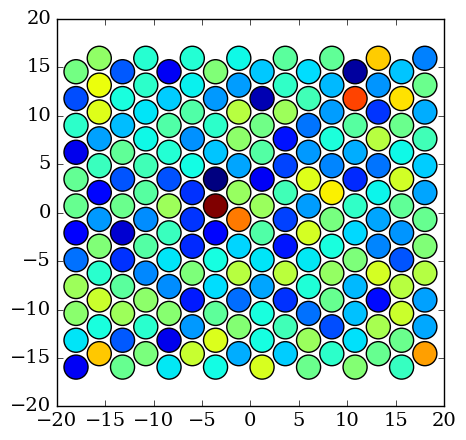

In [211]:

def scatterPlot(x,y,z,colors,mini,maxi):
    pos=num.logical_and(z>mini,z<maxi)
    print(num.max(colors[pos]))
    plt.scatter(x[pos],y[pos],c=colors[pos],s=300)
    

scatterPlot(x[:-1],y[:-1],z[:-1],charge[:-1],13,15)


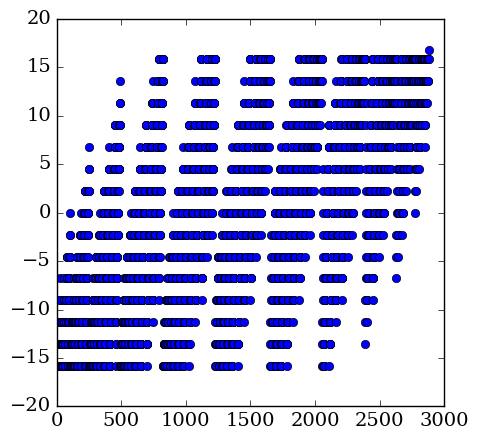

In [206]:
lab.plot(z,'o')

0.3043561


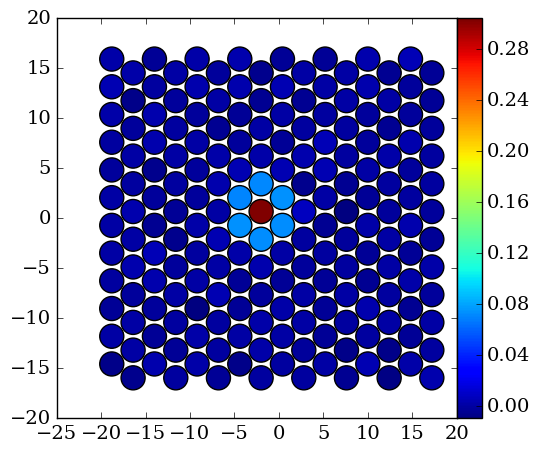

In [212]:
import matplotlib.pyplot as plt
def scatterPlot(x,y,z,colors,mini,maxi):
    fig=plt.figure()
    ax=fig.add_axes([0.1,0.1,0.8,0.8])
    pos=num.logical_and(z>mini,z<maxi)
    print(num.max(colors[pos]))
    plot=ax.scatter(x[pos],y[pos],c=colors[pos],s=300)
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    #ax.set_xticks([])
    #ax.set_yticks([])
    colorbar_ax=fig.add_axes([0.9,0.1,0.05,0.8])
    fig.colorbar(plot,cax=colorbar_ax)

    
scatterPlot(x[:-1],y[:-1],z[:-1],charge[:-1],15,17)